###$\color{blue}{\text{2.0. Environmental Set-up & Data Loading}}$

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Google Drive where you have saved the unzipped
FOLDERNAME =  'ADX/'

assert FOLDERNAME is not None, 'ERROR'

%cd drive/My\ Drive
%cp -r $FOLDERNAME ../../

Mounted at /content/drive
/content/drive/My Drive


In [ ]:
import pandas as pd
import numpy as np

# Part 1.1에서 전처리하여 저장한 데이터 Import
df = pd.read_pickle('./ADX/Data_RealEstate/dataset_preprocessing_team1re.pickle')
y_price = df.loc[:, '거래금액(만원)_adj']
df_ = df.drop('거래금액(만원)_adj', 1)

# 추후에 Implementation for Real-World Practice에 사용할 Test Data (교수자만 소유)
# df_test = pd.read_csv('./ADX/Data_RealEstate/testset.csv', encoding ='cp949')

<ipython-input-2-a339a23ac502>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_ = df.drop('거래금액(만원)_adj', 1)


In [ ]:
# 한글 나눔포트 사용
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 9,599 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-nanum all 20180306-3 [9,599 kB]
Fetched 9,599 kB in 1s (6,915 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 128276 files and di

###$\color{blue}{\text{2.1. Data split & Normalization}}$

모델을 튜닝하기 위한 validation set 설정

In [ ]:
def splitData(df, ratio, y_column):
    
    columns_ = df.columns
    # Subsample the data
    mask = list(range(0,df.shape[0], ratio))
    X_val = df.iloc[mask, :].drop(y_column, 1)
    y_val = df.iloc[mask][y_column]
    
    mask = ~df.index.isin(mask)
    X_train = df.loc[mask, :].drop(y_column, 1)
    y_train = df.loc[mask, y_column]
    
    return X_train, y_train, X_val, y_val

# train set, validation set split 
# train set, validation set = 4 : 1

X_train, y_train, X_val, y_val = splitData(df_, 5, y_column = '평당가격') 


#################################################################################
# TODO: 연속형 변수에 대해서 Z normalize를 설계 및 적용                         #
# 대표적으로 Z normalize와 min max normalize가 존재 
#
# 1. training dataset에 normalize하는 함수 생성(validation/ test에 사용할 cache 
# 저장)
# 2. validation set과 test set을 normalize하는 함수 생성 및 적용
#################################################################################

##1. 
def z_normalize(data, column):
    temp_df = data[column]
    normalized_df = (temp_df - temp_df.mean()) / temp_df.std()
    cache = {}
    cache['mean'] = temp_df.mean()
    cache['std'] = temp_df.std()
    return normalized_df, cache

    
##2. 

def z_normalize_val(data, column, cache):
    temp_df = data[column]
    normalized_df = (temp_df - cache['mean']) / cache['std']
    return normalized_df


<ipython-input-6-f82f78080330>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_val = df.iloc[mask, :].drop(y_column, 1)
<ipython-input-6-f82f78080330>:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = df.loc[mask, :].drop(y_column, 1)


In [ ]:
# 위 block에서 만들어진 z_normalize와 z_normalize_val 적용 (Error 날 경우 다시 고민할 것)
X_train_norm = X_train.copy()
X_train_norm.loc[:, ['전용/연면적(㎡)','층','건물년식']], cache = z_normalize(X_train, ['전용/연면적(㎡)','층','건물년식'])
X_val_norm = X_val.copy()
X_val_norm.loc[:, ['전용/연면적(㎡)','층','건물년식']] = z_normalize_val(X_val, ['전용/연면적(㎡)','층','건물년식'], cache)

###$\color{blue}{\text{2.2. Decision Tree for Regression}}$

Decision Tree (https://scikit-learn.org/stable/modules/tree.html)

**Hyperparameter Optimization (Tuning)**. Decision Tree에서는 max_depth를 바꿔가며 현재 split 된 데이터에 최적의 모델을 찾을 것 (loop을 통해 여러 depth를 테스트하며 최소값은 3에서 시작)

**Approximate results**. ㎡당 가격의 MAE와 ㎡당 가격을 추정 상가 가격으로 변환하여 MAE를 계산 (MAE의 minimum을 찾는 행위가 Hyperparameter optimization을 의미하며 최대로 개선된 모형을 사용하는 것이 바람직함)

current best parameter:  3 with mse : 673645.151904038 with mae : 503.08137352208195
current best parameter:  4 with mse : 643165.2065766461 with mae : 493.0565299780062
current best parameter:  5 with mse : 617507.2056665389 with mae : 478.44436234761423
current best parameter:  6 with mse : 591081.206614557 with mae : 462.94823199147174
current best parameter:  7 with mse : 541178.4157913654 with mae : 437.2855442824957
current best parameter:  8 with mse : 492472.66690800816 with mae : 414.13441134080045
current best parameter:  9 with mse : 452076.7796055632 with mae : 394.18127691666194
current best parameter:  10 with mse : 408032.5951835195 with mae : 373.51282907209145
current best parameter:  11 with mse : 370226.56349510414 with mae : 348.5864948320152
current best parameter:  12 with mse : 334261.4582105708 with mae : 328.99097788297126
current best parameter:  13 with mse : 312767.8744238171 with mae : 309.79078168504424
current best parameter:  14 with mse : 278431.3922317

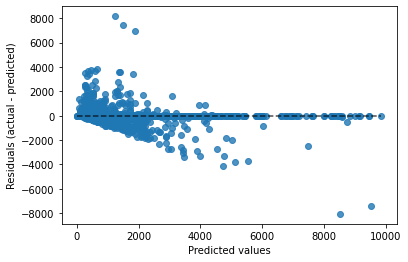

In [ ]:
from sklearn.tree import DecisionTreeRegressor
best_dt = None  # store the best model into this 
best_mse = 1e10  # Initial set-value, which must be changed later on
best_hyperparameter = None
results = {}
max_depths = [3, 4, 5, 10, 20, 50]



#################################################################################
# TODO: validation dataset을 활용하여 하이퍼 파라미터를 조정하고 가장 좋은 모델  
# 을 저장하여 추후 test dataset에 적용해볼 예정                                 
#                                                                               
# 1. max_depth을 조절하여 가장 좋은 모델을 'best_dt'에 저장, 가장 
# 좋은 모델의 하이퍼 파라미터를 'best_hyperparamter'에 저장. 모델의 성능 비교는
# validation set의 MSE를 참조하고 가장 좋은 모델의 MSE를 'best_MSE'에 저장.
#
# 2. Regression 결과를 plot 할 것 (위의 scikit-learn 문서 참조)
#################################################################################

from sklearn.tree import DecisionTreeRegressor
best_dt = None  # store the best model into this 
best_mse = 1e10  # Initial set-value, which must be changed later on
best_hyperparameter = None
results = {}
#max_depth의 범위를 늘려서 실험
max_depths = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 30, 40, 50, 60, 70, 80, 90, 100]


#################################################################################
# TODO: validation dataset을 활용하여 하이퍼 파라미터를 조정하고 가장 좋은 모델  
# 을 저장하여 추후 test dataset에 적용해볼 예정                                 
#                                                                               
# 1. max_depth을 조절하여 가장 좋은 모델을 'best_dt'에 저장, 가장 
# 좋은 모델의 하이퍼 파라미터를 'best_hyperparamter'에 저장. 모델의 성능 비교는
# validation set의 MSE를 참조하고 가장 좋은 모델의 MSE를 'best_MSE'에 저장.
#
# 2. Regression 결과를 plot 할 것 (위의 scikit-learn 문서 참조)
#################################################################################


from sklearn.metrics import mean_squared_error, mean_absolute_error

best_mae = 1e10   #MAE를 기준으로 best hyperparameter를 찾기 위함

for i in max_depths: #max_depth를 바꿔가며 실행
    tmp_model = DecisionTreeRegressor(max_depth = i)
    tmp_model.fit(X_train_norm, y_train)
    y_pred = tmp_model.predict(X_val_norm)
    tmp_mae = mean_absolute_error(y_val, y_pred)
    #best_mae를 최소 mae일 경우 갱신
    if tmp_mae <= best_mae:
        best_dt = tmp_model
        best_mae = tmp_mae
        best_mse = mean_squared_error(y_val, y_pred)
        best_hyperparameter = i
        print("current best parameter: ", best_hyperparameter,"with mse :", best_mse,"with mae :",best_mae)
    
    #각 max_depth별 결과를 저장
    results[i] = y_pred

print("Best hyperparameter is ", best_hyperparameter)
print("that MSE is ", best_mse, "that MAE is", best_mae)

#best model의 오차 plot
from sklearn.metrics import PredictionErrorDisplay
disp = PredictionErrorDisplay(y_true=y_val, y_pred=results[best_hyperparameter])
disp.plot()


<function matplotlib.pyplot.show(close=None, block=None)>

<Figure size 432x288 with 0 Axes>

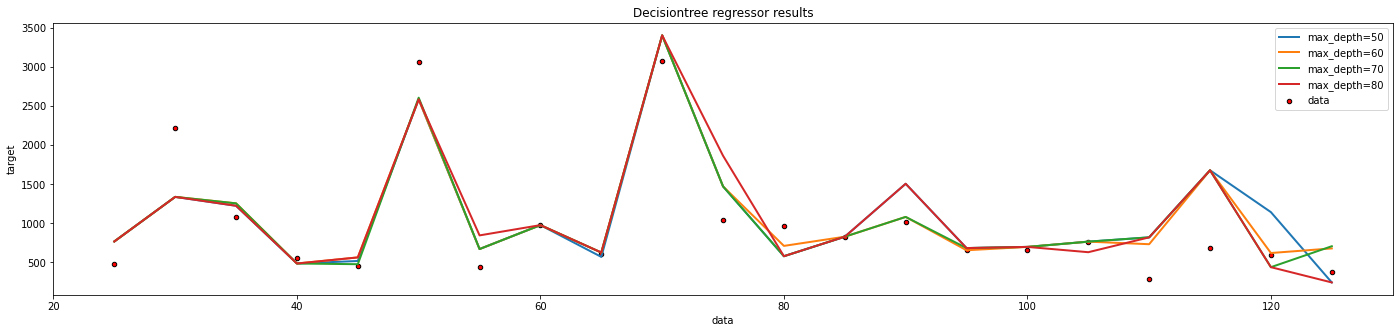

In [ ]:
#max_depth별 plot
import matplotlib.pyplot as plt

plt.clf()
plt.figure(figsize=(24,5))

#가시성을 위해 validation set의 20개 data만 plot
x_to_plot = X_val_norm[5:26]
y_to_plot = y_val[5:26]

#실험 결과 50~80에서 best dt가 자주 나왔으므로 해당 부분만 plot
plot_depth = list(range(50,90,10))
for depth in plot_depth:
    pred_plot = results[depth][5:26]
    label = 'max_depth='+str(depth)
    plt.plot(x_to_plot.index, pred_plot, label=label, linewidth=2)

plt.scatter(x_to_plot.index, y_to_plot, s=20, edgecolors='black', c='red', label = 'data')
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decisiontree regressor results")
plt.legend()
plt.show

In [ ]:
# Print your validation 거래금액 mae
# 위 코드 결과물을 기반으로 계산 (에러가 난다면 본 코드를 수정하거나 위 코드를 수정하여야 함)

#####정규화된 값으로 변경함
print('Validation MSE(㎡당 가격): ', np.mean(np.square(best_dt.predict(X_val_norm) - y_val)))
print('Validation MAE(㎡당 가격):', np.mean(np.abs(best_dt.predict(X_val_norm) - y_val)))

_price = X_val.loc[:, '전용/연면적(㎡)'] * best_dt.predict(X_val_norm)

print('Validation MSE(거래 금액): ', np.mean(np.square(_price - y_val)))
print('Validation MAE(거래 금액): ', np.mean(np.abs(_price - y_val)))
print('Best parameters : ', best_hyperparameter)

Validation MSE(㎡당 가격):  110355.10147290626
Validation MAE(㎡당 가격): 61.719647892789006
Validation MSE(거래 금액):  1950152560933.7246
Validation MAE(거래 금액):  174463.56185211183
Best parameters :  80


###$\color{blue}{\text{2.3. Implementation for Real-World Practice}}$

새로운 데이터가 들어왔을 때, 지금까지 구현 된 과정을 자동으로 거쳐 새로운 input으로서 모델에 입력하고 산출물을 받을 수 있도록 구현 (test-set 개념으로 진행)

In [ ]:
testy = df_test.loc[:, '거래금액(만원)']
y_real = []
for i in np.array(df_test.loc[:, '거래금액(만원)']) :
    y_real.append(float(i.replace(',', '')))
df_test = df_test.drop('거래금액(만원)', 1)
y_price = y_real / df_test.loc[:, '전용/연면적(㎡)']

In [ ]:
import datetime
import math

# 하기의 새로운 df를 2.1에 제시 된 df로 간주하고 진행할 것.
df = df_test.copy()

#################################################################################
# TODO: Test set 동일한 처리과정 만들기                                         #
#                                                                               
# Part 1.1에서 만든 방법론을 적용 (Null은 없다고 가정 - 이미 처리했음)
# 1. 데이터 타입처리 (계약년월, 건축년도)
# 2. 지역구 단위의 행정구역 새로운 변수 생성 (변수명 '지역구')
# 3. 건물 년식 일 단위로 하여 새로운 변수 생성 (변수명 '건물년식') 
# 4. 평당가격 변수 추가 
# 5. 과제 1에서 만든 새로운 파생 변수 생성  
#################################################################################


#1.
##추후에 건물 년식을 계산할 것이므로 계약날짜(계약년월 + 계약일)와 건축년도를 datetime 형식으로 변환, 건축년도는 1월1일로 가정하고 datetime으로 append
contract_date = []
for i, j in np.array(df[['계약년월', '계약일']]):
  contract_date.append(datetime.datetime(int(str(i)[:4]), int(str(i)[4:6]), int(j))) ##string, int 타입을 datetime 으로 변환
df['계약날짜'] = contract_date ##계약날짜라는 변수 생성

construct_yr = []
for i in np.array(df['건축년도']):
  construct_yr.append(datetime.datetime(int(i), 1, 1)) ##1월 1일로 가정하고 datetime 으로 변환
df['건축년도'] = construct_yr ##건축년도 column 타입 변환


#2.
##지역구에 대한 예외 처리가 필요함. **구 라고 나온 값만 뽑아 넣고 싶음, 해당 구 찾고 지역구 칼럼 만들기
gu_list2 = ['중구']
gu_list3 = ['종로구','용산구','성동구','광진구','중랑구','성북구','강북구','도봉구','노원구','은평구','마포구','양천구','강서구','구로구','금천구','동작구','관악구','서초구','강남구','송파구','강동구']
gu_list4 = ['서대문구', '동대문구', '영등포구']

def find_gu(st):
    for i in range(0, len(st)):
        if st[i] == '구' :
            tmp = st[i - 2 : i + 1]
            if tmp in gu_list3:
                return tmp
            
            tmp = st[i - 3 : i + 1]
            if tmp in gu_list4:
                return tmp
            else:
                return gu_list2[0]

df['지역구'] = df['시군구'].apply(find_gu)


#3. 계약날짜 - 건축년도 하고 날짜로 처리한 다음 건물년식이라는 column 추가
df.loc[:, '건물년식'] = df.apply(lambda x : (x['계약날짜'] - x['건축년도']).days, axis = 1)


#4. 평당가격 예측 값을 담기위한 빈 칼럼('평당가격') 추가, 0으로 초기화
df.loc[:, '평당가격'] = 0.0


#5
##지역구 열을 통해 종합주택가격지수라는 새로운 변수를 만들어 볼것임.(해당 지역 건물의 가격을 100으로 기준잡고 등락을 숫자로 보여주는 것)
##출처 : https://data.seoul.go.kr/dataList/801/S/2/datasetView.do  
Price_idx = {'종로구':100.2,'중구':96.9,'용산구':101.4,'성동구':99.0,'광진구':100.0,'동대문구':97.7,
      '중랑구':98.8,'성북구':96.5,'강북구':98.8,'도봉구':96.0,'노원구':93.8,'은평구':98.3,
     '서대문구':97.4,'마포구':98.8,'양천구':99.1,'강서구':98.6,'구로구':99.0,'금천구':98.5,
     '영등포구':98.1,'동작구':100.2,'관악구':98.7,'서초구':103.1,'강남구':101.2,'송파구':98.8,'강동구':99.0}
df.loc[:, '매매가격지수'] = df['지역구'].apply(lambda x:Price_idx[x])



##범주형 변수들을 수치형 변수들로 변환(one-hot encoding)
CATEGORICAL = ['용도지역', '건축물주용도', '도로조건','지역구']
df_1 = df.loc[:,[ '전용/연면적(㎡)', '층', '건물년식', '평당가격']]

for i in CATEGORICAL :
  if i not in df.columns:
    continue
  cate_i = pd.get_dummies(df.loc[:,i])
  df_1[cate_i.columns] = cate_i

df = df_1.copy()


In [ ]:
#################################################################################
# TODO: One hot encoding의 컬럼수 조정                                          #
#                                                                               #
# 1. training set과 test set의 범주형 변수의 종류가 달라질 수 있으므로 이를 train  
#  set의 컬럼으로 통일 (index.isin() 활용)                                         
#################################################################################

#1

##df는 여기서 test set의 dataframe
##X_train은 training set
for i in df.columns:
  if i not in X_train.columns:
    df.drop(i, 1, inplace = True) 
##df의 column을 보는데, X_train에 없는 column은 모두 없앰

to_add =[]
for i in X_train.columns:
  if i not in df.columns:
    to_add.append(i)
col_dic = {}
idx = df.index.to_list() 

for j in to_add:
  col_dic[j] = [0 for k in range(df.shape[0])]
add_df = pd.DataFrame(col_dic, index=idx)
##train set에는 존재하지만 test set에는 없는 column들을 생성해서 데이터프레임화 (0으로 초기화)

df = pd.concat([df, add_df], axis=1) 
df = df[X_train.columns.to_list()]
##기존 데이터프레임(df)과 위에서 생성한 새로운 데이터프레임을 합치고 column들을 정렬

In [ ]:
#################################################################################
# TODO: Normalize : training set을 기준으로 진행                                #
#                                                                               #
# 1. training set의 cache를 활용하여 test set normalize    
# ---- z_normalize_val(____, cache)                           
#################################################################################

## 2.2에서 정의한 normalize 함수를 적용하여 test set 정규화

X_test = df 
X_test_norm = X_test.copy()
X_test_norm.loc[:, ['전용/연면적(㎡)','층','건물년식']] = z_normalize_val(X_test, ['전용/연면적(㎡)','층','건물년식'], cache) 


In [ ]:
# Print your test 거래금액 Mean Absolute Error

print('Validation MSE(㎡당 가격): ', np.mean(np.square(best_dt.predict(X_test_norm) - y_price)))
print('Validation MAE(㎡당 가격):', np.mean(np.abs(best_dt.predict(X_test_norm) - y_price)))

_price = X_test.loc[:, '전용/연면적(㎡)'] * best_dt.predict(X_test_norm)

print('Validation MSE(거래 금액): ', np.mean(np.square(_price - y_real)))
print('Validation MAE(거래 금액): ', np.mean(np.abs(_price - y_real)))